In [1]:
from binance.client import Client
import os
import json
from binance import ThreadedWebsocketManager
import numpy as np
import pandas as pd
from talib.abstract import EMA, STOCH, MA

In [2]:
with open('../config/key.json') as j:
    keys = json.load(j)

In [3]:
client = Client(keys['api_key'], keys['api_secret'])
dict_data = {'error':False}
bsm = ThreadedWebsocketManager()

In [4]:
plot_low = []
plot_hight = []
plot_stoch_k = []
plot_stoch_d = []

In [5]:
def buyORsell(ema_low,ema_hight):
#     buy 100>200
    plot_low.append(ema_low[-1])
    plot_hight.append(ema_hight[-1])
    if ema_low[-1]>ema_hight[-1]:
        return 0 #False
#     sell 100<200
    elif ema_low[-1]<ema_hight[-1]:
        return 1 #True

    return 3

In [6]:
data = {
    "price_buy":[],
    "price_sell":[],
    "p_open":0,
    "status":True,
    "sell":0,
    "sw":False,
    "first":True,
    "symbol":"ETHBUSD",
    "starttime": "30 day ago UTC",
    "interval":"1m",
    "low_span":100,
    "hight_span":200
}

print('init get data')
bars = client.get_historical_klines(data["symbol"], data["interval"], data["starttime"])
# hight, low, close
bars = [line[2:5] for line in bars]
df = pd.DataFrame(bars, columns=['hight','low','close'])
print('finish get data')

def btc_trade_history(msg):
    global data,bsm,df

    if data['status'] != True:
        bsm.stop()
        
    if msg['e'] != 'error':
#         calculate
        if data['first']:
            data['first'] = False
            data['p_open'] = msg['k']['o']
            print('p_open:',data['p_open'])
        else:
            if float(msg['k']['o']) != float(data['p_open']):
                # state change 
                print('state change:',data['p_open'])
                df = df.iloc[1: , :]
                df2 = pd.DataFrame({'hight':float(msg['k']['h']), 'low':float(msg['k']['l']), 'close':float(msg['k']['c'])},index=[0])
                df = pd.concat([df, df2], ignore_index = True, axis = 0)
                
        if float(msg['k']['o']) != float(data['p_open']) or data['first']:
            # calculate EMA100 and EMA200
            # print(f"price o:{msg['k']['o']}, price c:{msg['k']['c']}")
            low_df = EMA(df['close'],data['low_span'])
            hight_df = EMA(df['close'],data['hight_span'])
            sORb = buyORsell(low_df, hight_df)
            slowk, slowd = STOCH(df['hight'],df['low'],df['close'])
            plot_stoch_k.append(slowk[-1])
            plot_stoch_d.append(slowd[-1])

            # sell
            if data['sw']:
                # check price sell>buy
                if sORb and slowk[-1] < slowd[-1] and slowk[-1] >= 80 and slowd[-1] >= 80:
                    if float(msg['k']['c']) > float(data["price_buy"][-1]):
                        # order_sell = client.order_market_sell(symbol=data['symbol'],quantity=round(float(sell_price),4))
                        # print('order_sell:',order_sell)
                        data["price_sell"].append(msg['k']['c'])
                        # save price sell
                        data['price'] = msg['k']['c']
                        print('sell:',data['price'])
                        # change status sw to False
                        data['sw'] = False
            # buy
            else:
                if not sORb and slowk[-1] > slowd[-1] and slowk[-1] <= 10 and slowd[-1] <= 10:
                    # order_buy = client.order_market_buy(symbol=data['symbol'],quantity=buy_coin)
                    data["price_buy"].append(msg['k']['c'])
                    print('buy:',msg['k']['c'])
                    # data["price"] = float(msg['k']['o'])
                    data['sw'] = True
                    
            # change value
            data['p_open'] = msg['k']['o']
            print('changed:',data['p_open'])
                    
        dict_data['error'] = False
    else:
        dict_data['error'] = True

init get data
finish get data


In [30]:
data["price_sell"]

['1710.14']

In [31]:
data["price_buy"]

['1704.94', '1705.41']

state change: 1661.44
changed: 1661.21
state change: 1661.21
changed: 1662.39
state change: 1662.39
changed: 1660.90
state change: 1660.90
changed: 1660.35
state change: 1660.35
changed: 1658.99
state change: 1658.99
changed: 1659.22
state change: 1659.22
changed: 1660.70
state change: 1660.70
changed: 1660.40


In [11]:
import matplotlib.pyplot as plt

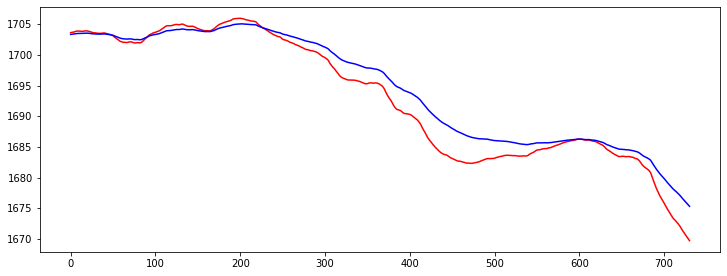

state change: 1660.40
changed: 1661.53


In [32]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(plot_low, color= 'red')
plt.plot(plot_hight, color= 'blue')
plt.show()

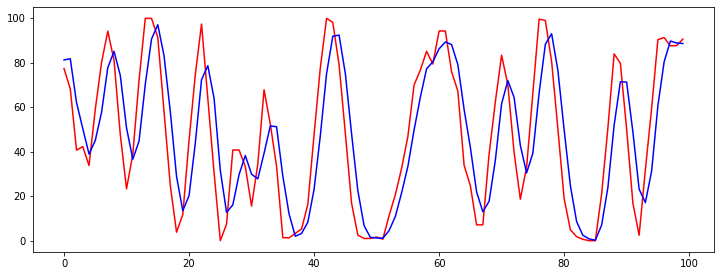

state change: 1662.66
changed: 1662.95
state change: 1662.95
changed: 1662.02
state change: 1662.02
changed: 1661.89


In [35]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(plot_stoch_k[-100:], color= 'red')
plt.plot(plot_stoch_d[-100:], color= 'blue')
plt.show()

In [17]:
plot_stoch_k[-1][-1]

24.041585445094217

In [7]:
bsm.start()
print('starting ...... ')
# bsm.start_symbol_ticker_socket(callback=btc_trade_history, symbol=data["symbol"])
bsm.start_kline_futures_socket(callback=btc_trade_history, symbol=data["symbol"],interval="1m")
# bsm.start_kline_socket(callback= btc_trade_history,symbol=data["symbol"])

starting ...... 


'ethbusd_perpetual@continuousKline_1m'

p_open: 1705.39
state change: 1705.39
changed: 1705.16
state change: 1705.16
changed: 1705.41


In [18]:
bsm.stop()

In [8]:
plot_low

[1703.625433438256, 1703.6609694097758]

In [9]:
plot_hight

[1703.3370980896625, 1703.357823481805]